In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import sympy as sym

In [2]:
def linfty_norm(fun,a=0,b=1,nn=12):
    xx = np.linspace(a,b,2**nn+1)
    return np.amax(np.absolute(fun(xx)))

def lagrangian_interpolation_matrix(x,q):
    n = q.shape[0]-1
    Ln = np.zeros((n+1, len(x)))

    for i in xrange(n+1):
        Ln[i] = np.product([ (x-q[j])/(q[i]-q[j]) for j in xrange(n+1) if j != i], axis=0)
        
    return Ln

def lagrangian_interpolation(f,q):
    return lambda x : np.dot(np.transpose(lagrangian_interpolation_matrix(x,q)),f(q))

def omega_tensor(q):
    _n = q.shape[0]-1
    return lambda x : np.product([x-q[i] for i in xrange(_n+1)], axis = 0)
    

In [5]:
def compute_error_estimate(symf, maxgrade=20, npoints=1025, a=0, b=1):
    x = np.linspace(a,b,npoints)

    # numpy array
    nf = sym.lambdify(t,f, 'numpy') 

    pl.figure(figsize=[10,5])



    for n in xrange(2,maxgrade):
        # The interpolation points
        q = np.linspace(a,b,n+1)
    
        l = lagrangian_interpolation(nf,q)
    
        df = sym.diff(f,t,n+1)
        dnf = sym.lambdify(t,df, 'numpy')
        w = omega_tensor(q)
    
        lhs_linfty = linfty_norm(lambda x : nf(x)-l(x),a,b)
        df_linfty = linfty_norm(lambda x : dnf(x)-l(x),a,b)
        w_linfty = linfty_norm(lambda x : w(x),a,b )
        w_linfty /= np.math.factorial(n+1)
    
        rhs_linfty = df_linfty * w_linfty

        #figure(figsize=[10,5])
        _ = pl.semilogy (n,lhs_linfty, 'ro')
        #_ = pl.semilogy(n,df_linfty, 'y.') # linfty norm of the n+1 derivative
        #_= pl.semilogy(n,w_linfty, 'b+') # linfty norm of w(x)/(n+1)!
        _= pl.semilogy(n,rhs_linfty, 'g*')
    

    # plot the interpolation at the LAST iteration
    pl.figure(figsize=[10,5])
    _ = pl.plot(x, nf(x))
    _ = pl.plot(x, l(x))
    _ = pl.plot(q, nf(q), 'ro')
    

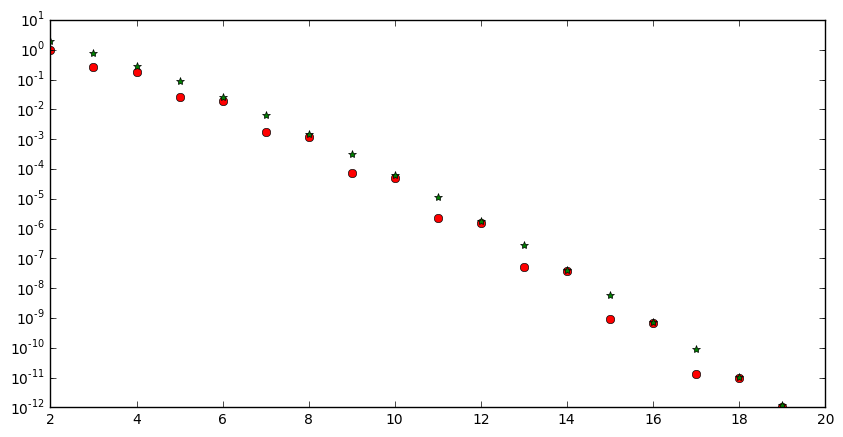

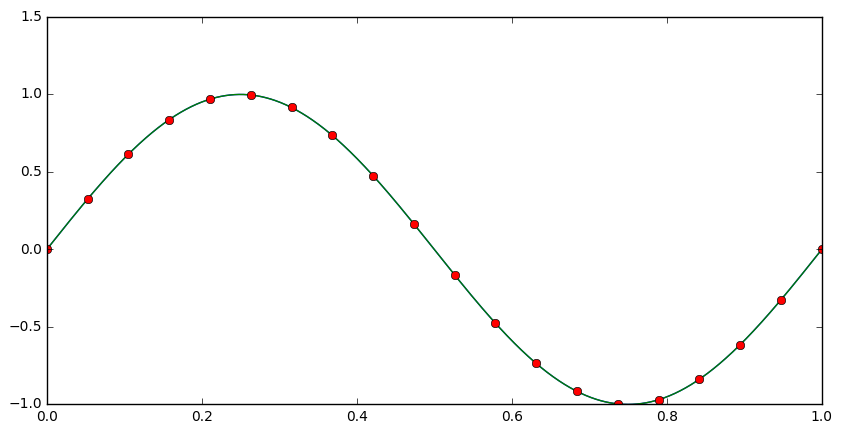

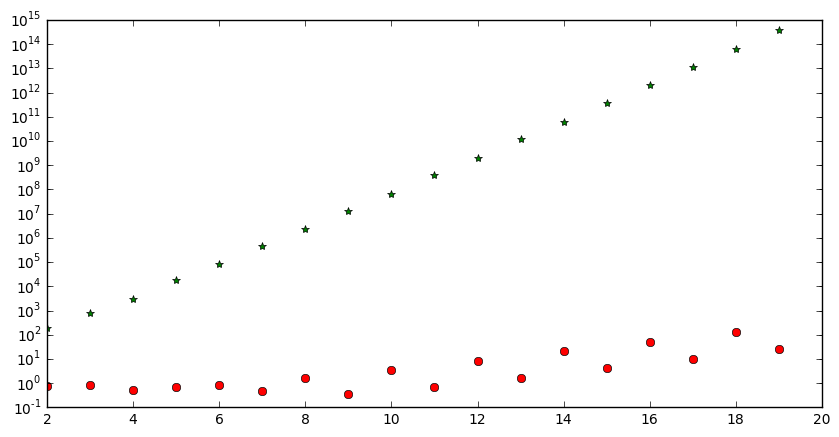

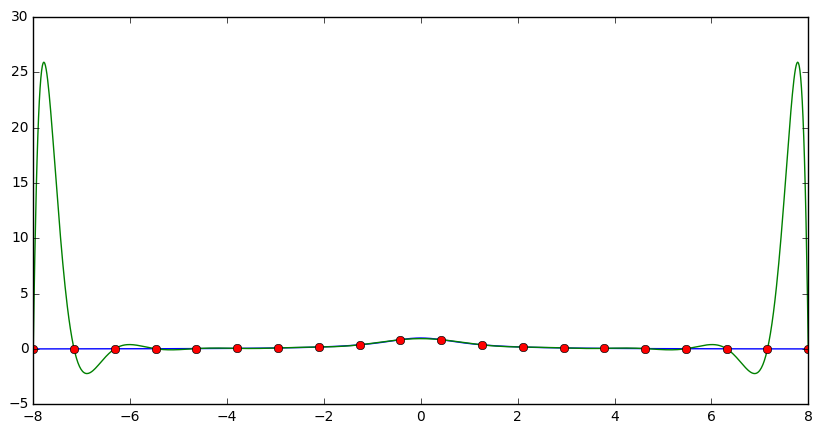

In [6]:

t = sym.symbols('t')

f = sym.sin(2.*sym.pi*t)


compute_error_estimate(f,20,1025,0,1)

f = 1/(1+t*t)
compute_error_estimate(f,20,1025,-8,8)